In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr
from scipy.interpolate import griddata
import geopandas as gpd
from pyproj import Proj, transform
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import glob

In [15]:
list_files=glob.glob('/Users/hamidrezaomidvar/Desktop/LINDER/Colombo/fraction*')
df=pd.concat([pd.read_csv(f,index_col=0) for f in list_files])
df.columns=['lat','lon','Fr_Paved' ,'Fr_Grass','Fr_Water' ,'Fr_Bsoil','Fr_Bldgs']
df['Fr_EveTr']=0
df['Fr_DecTr']=0
df.head()

,lat,lon,Fr_Paved,Fr_Grass,Fr_Water,Fr_Bsoil,Fr_Bldgs,Fr_EveTr,Fr_DecTr
0,6.899419,79.811364,0.0,0.0,1.0,0.0,0.0,0,0
1,6.896995,79.811364,0.0,0.0,1.0,0.0,0.0,0,0
2,6.894570,79.811364,0.0,0.0,1.0,0.0,0.0,0,0
3,6.892146,79.811364,0.0,0.0,1.0,0.0,0.0,0,0
4,6.889721,79.811364,0.0,0.0,1.0,0.0,0.0,0,0


In [16]:
lat=df['lat']
lon=df['lon']

In [31]:
p2_text='''
+units=m +init=ESRI:102009 +proj=lcc +lat_1=30 +lat_2=60 +lat_0=6.92 +lon_0=79.86 
+x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +no_defs +towgs84=0,0,0
'''

p1 = Proj(init='epsg:32631')
p2 = Proj(p2_text)
x1, y1 = p1(list(lon),list(lat))
x2, y2 = transform(p1,p2,x1,y1)

In [32]:
x_file='wrfinput_d03.suews'
ds_base = xr.open_dataset(x_file)
wrf_LAT=ds_base.XLAT.values[0,:,:]
wrf_LON=ds_base.XLONG.values[0,:,:]


wrf_X,wrf_Y=p2(wrf_LON,wrf_LAT)

In [33]:
def pc_plot(grid_x, grid_y,new_Z,name):
    plt.figure(figsize=(10,10))
    plt.pcolor(grid_x, grid_y,new_Z)
    plt.colorbar()
    plt.title(name)
    plt.ylabel('y')
    plt.xlabel('x')
    plt.savefig('fig/'+name+'.png', dpi=300, bbox_inches='tight', pad_inches=0.01)

In [34]:
def regrid_lower(name):
    Z=df[name]
    grid_x=wrf_X
    grid_y=wrf_Y
    new_Z=griddata(list(zip(x2,y2)), Z.values, (grid_x, grid_y), method='linear')
    return grid_x, grid_y,new_Z

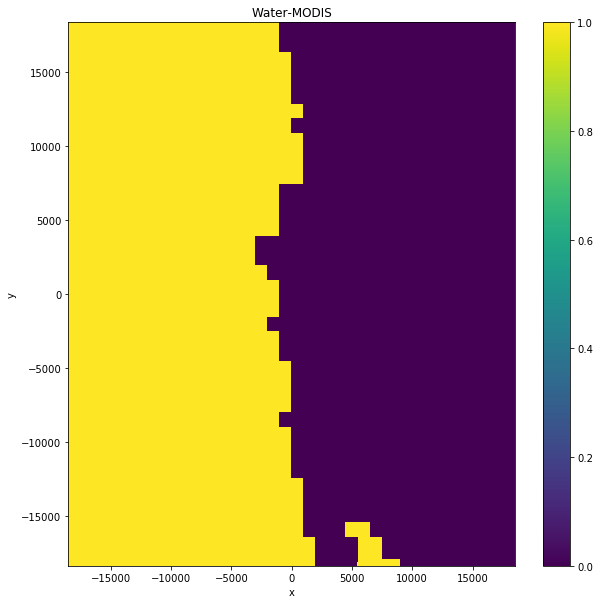

In [35]:
pc_plot(wrf_X, wrf_Y,ds_base['LANDUSEF'].values[0,16,:,:],'Water-MODIS')

In [36]:
names=['Fr_Paved' ,'Fr_Bldgs' ,'Fr_EveTr' ,'Fr_DecTr' ,'Fr_Grass' ,'Fr_Bsoil','Fr_Water']
new_all={}
for name in names:
    print(name)
    grid_x, grid_y,new_0=regrid_lower(name)
    new_all[name]=new_0

Fr_Paved
Fr_Bldgs
Fr_EveTr
Fr_DecTr
Fr_Grass
Fr_Bsoil
Fr_Water


In [37]:
new_0=new_all['Fr_Paved']
cd=~np.isnan(new_0)
ds_base['LANDUSEF'].values[0,12,:,:][cd]=new_all['Fr_Paved'][cd]+new_all['Fr_Bldgs'][cd]
ds_base['LANDUSEF'].values[0,12,:,:][cd]=np.round(ds_base['LANDUSEF'].values[0,12,:,:][cd],2)

ds_base['LANDUSEF'].values[0,0,:,:][cd]=new_all['Fr_EveTr'][cd]/3
ds_base['LANDUSEF'].values[0,1,:,:][cd]=new_all['Fr_EveTr'][cd]/3
ds_base['LANDUSEF'].values[0,4,:,:][cd]=new_all['Fr_EveTr'][cd]/3

ds_base['LANDUSEF'].values[0,2,:,:][cd]=new_all['Fr_DecTr'][cd]/2
ds_base['LANDUSEF'].values[0,3,:,:][cd]=new_all['Fr_DecTr'][cd]/2

ds_base['LANDUSEF'].values[0,5,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,6,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,7,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,8,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,9,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,11,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,13,:,:][cd]=new_all['Fr_Grass'][cd]/7

ds_base['LANDUSEF'].values[0,15,:,:][cd]=new_all['Fr_Bsoil'][cd]/4
ds_base['LANDUSEF'].values[0,17,:,:][cd]=new_all['Fr_Bsoil'][cd]/4
ds_base['LANDUSEF'].values[0,18,:,:][cd]=new_all['Fr_Bsoil'][cd]/4
ds_base['LANDUSEF'].values[0,19,:,:][cd]=new_all['Fr_Bsoil'][cd]/4


#ds_base['LANDUSEF'].values[0,10,:,:][cd]=new_all['Fr_Water'][cd]/2
ds_base['LANDUSEF'].values[0,16,:,:][cd]=new_all['Fr_Water'][cd]

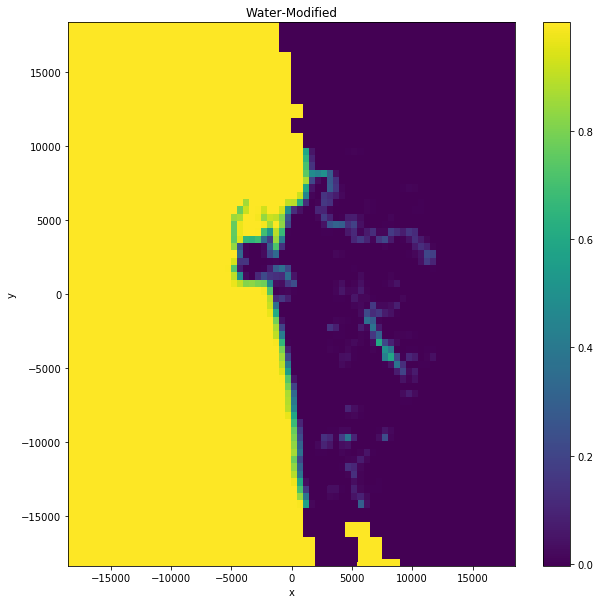

In [38]:
pc_plot(wrf_X, wrf_Y,ds_base['LANDUSEF'].values[0,16,:,:],'Water-Modified')

In [102]:
ds_merged = ds_base.update(ds_base)    

for var in ds_merged.data_vars.keys():
    if 'coordinates' in ds_merged[var].attrs:
        del ds_merged[var].attrs['coordinates']
        
file_out = x_file+'.new'

ds_merged.to_netcdf(file_out,
                    mode='w', format='NETCDF3_64BIT')
print('SUEWS input has been added to:' + file_out)

SUEWS input has been added to:wrfinput_d03.suews.new
